# Step 3. Evaluation
----
### Objective
1. Endpoint상에서의 inference 없이 빠르고 간편하게 모델 성능을 평가해 봅니다.
2. XGBoost와 LightGBM으로 학습한 모델의 성능을 동일한 검증셋으로 비교합니다. 성능 비교 지표는 AUROC(Area Under the Receiver Operating Characteristic)외에 추가로 AUPRC(Area Under Precision-Recall Curve)를 같이 확인합니다.

**[왜 AUPRC를 같이 확인하나요?]**
- 아래 그림에서 확인할 수 있듯이 Precision-Recall Curve(PR Curve)는 극도로 불균형한 데이터셋의 평가에 매우 적절합니다. 
- AUROC는 최소값이 0.5이고 Positive class의 예측 결과에 덜 민감한 반면, AUPRC는 최소값이 0이고 Positive class의 예측 결과에 매우 민감합니다.
- 좀 더 자세히 언급하자면, ROC Curve의 x축은 False Positive Rate (i.e., 1-Specificity)로 $\text{False Positive Rate} = \dfrac{FP}{FP + TN}$인데 비해, PR Curve의 y축은 Precision으로 $\text{Precision} = \dfrac{TP}{TP + FP}$이기 때문입니다.
![fig1](auprc_img1.png)![fig2](auprc_img2.png)    

In [1]:
import boto3
import os
import numpy as np
import pandas as pd

s3 = boto3.client('s3')
feature_dir_name = 'modeling-feature-190808'     
bucket = 'analytics-preprocessed-daekeun'    # s3 bucket name
dataset = 'homecredit'
prefix_target = os.path.join(dataset, feature_dir_name)

<br>

## 1. Load Models
----
- S3에 저장된 모델 파일을 로컬 폴더로 복사 후, 모델을 로딩합니다.
- XGBoost는 모델을 pickle로 저장하였기 때문에 `pickle.load()`로 모델을 로딩해야 하며, LightGBM은 사용자 정의 컨테이너 구성 시에 pickle대신 LightGBM의 built-in function인 `save_model()`로 모델을 저장하였으므로, `lightgbm.Booster()`로 모델을 로딩해야 합니다.
- 모델 파일 로딩 방법은 아래 python code snippet을 참조해 주세요.
```python
model_xgb = pickle.load(open("xgboost-model", "rb"))
model_lgb = lgb.Booster(model_file='lightgbm_model.txt')
```

In [2]:
%%sh

# XGBoost basline model
export TRAINING_JOB_NAME='xgboost-2019-08-16-01-49-33-608'
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz
rm model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/xgboost-2019-08-16-01-49-33-608/output/model.tar.gz to ./model.tar.gz
xgboost-model


In [3]:
%%sh

# LightGBM model
export TRAINING_JOB_NAME='sagemaker-lightgbm-2019-08-16-06-36-02-968'
export MODEL_ARTIFACT=`aws sagemaker describe-training-job \
--training-job-name $TRAINING_JOB_NAME \
--query ModelArtifacts.S3ModelArtifacts \
--output text`

echo $MODEL_ARTIFACT

aws s3 cp $MODEL_ARTIFACT .
tar xvfz model.tar.gz
rm model.tar.gz

s3://analytics-preprocessed-daekeun/homecredit/output/sagemaker-lightgbm-2019-08-16-06-36-02-968/output/model.tar.gz
download: s3://analytics-preprocessed-daekeun/homecredit/output/sagemaker-lightgbm-2019-08-16-06-36-02-968/output/model.tar.gz to ./model.tar.gz
lightgbm_model.txt


<br>

## 2. Evaluation
----
- 본 데모의 경우 LightGBM으로 학습한 모델이 AUROC와 AUPRC가 XGBoost로 학습한 모델보다 높음을 확인할 수 있습니다. 
- XGBoost으로 학습한 모델은 False Positive 빈도가 매우 높은 반면 False Negative 빈도가 낮으며, LightGBM으로 학습한 모델은 False Positive 빈도가 매우 낮은 반면 False Negative 빈도가 높습니다.

In [5]:
#!pip install xgboost, lightgbm, joblib

    100% |████████████████████████████████| 142.8MB 364kB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import xgboost as xgb
import lightgbm as lgb
import joblib, pickle

val_data, val_y = joblib.load('trnval/valid.pkl')
dval = xgb.DMatrix(val_data.values)

model_xgb = pickle.load(open("xgboost-model", "rb"))
model_lgb = lgb.Booster(model_file='lightgbm_model.txt')

y_pred_xgb = model_xgb.predict(dval)
y_pred_lgb = model_lgb.predict(val_data.values)

### XGBoost

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     56263
           1       0.17      0.54      0.26      4942

   micro avg       0.76      0.76      0.76     61205
   macro avg       0.56      0.66      0.56     61205
weighted avg       0.89      0.76      0.81     61205



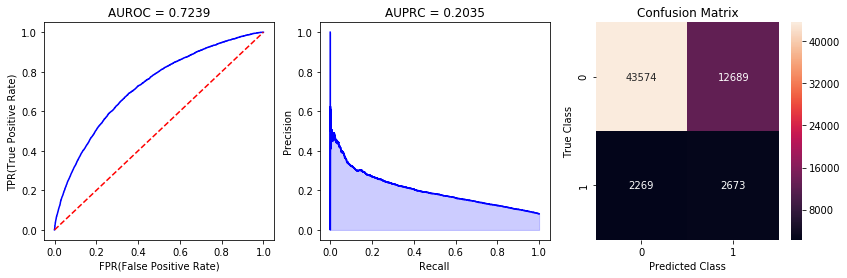

In [11]:
%matplotlib inline
from evaluate_fn import evaluate_prediction, get_score_df
evaluate_prediction(val_y.values, y_pred_xgb)

In [12]:
get_score_df(val_y.values, y_pred_xgb, start_score=0.0, end_score=0.7)

,Cutoff,TP,FP,TN,FN,Precision,Recall,F1,MCC
0,0.05,4942,56263,0,0,0.080745,1.000000,0.149425,0.000000
1,0.10,4940,55938,325,2,0.081146,0.999595,0.150106,0.020076
2,0.15,4909,53466,2797,33,0.084094,0.993323,0.155061,0.055832
3,0.20,4789,48847,7416,153,0.089287,0.969041,0.163508,0.083463
4,0.25,4615,42821,13442,327,0.097289,0.933832,0.176219,0.112711
5,0.30,4346,36122,20141,596,0.107393,0.879401,0.191412,0.136640
6,0.35,4043,29476,26787,899,0.120618,0.818090,0.210239,0.161035
7,0.40,3631,23192,33071,1311,0.135369,0.734723,0.228616,0.177090
8,0.45,3188,17545,38718,1754,0.153765,0.645083,0.248335,0.191830
9,0.50,2673,12689,43574,2269,0.174001,0.540874,0.263298,0.198147


### LightGBM

confusion matrix (cutoff=0.5)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56263
           1       0.60      0.04      0.07      4942

   micro avg       0.92      0.92      0.92     61205
   macro avg       0.76      0.52      0.51     61205
weighted avg       0.90      0.92      0.89     61205



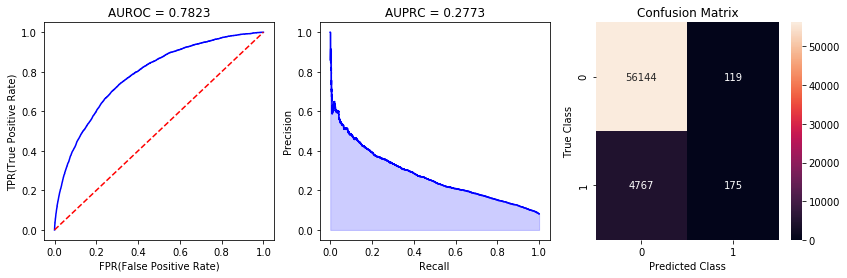

In [13]:
%matplotlib inline
from evaluate_fn import evaluate_prediction, get_score_df
evaluate_prediction(val_y.values, y_pred_lgb)

In [14]:
get_score_df(val_y.values, y_pred_lgb, start_score=0.0, end_score=0.7)

,Cutoff,TP,FP,TN,FN,Precision,Recall,F1,MCC
0,0.05,4196,26311,29952,746,0.137542,0.849049,0.236734,0.207824
1,0.10,3089,12101,44162,1853,0.203357,0.625051,0.306875,0.258576
2,0.15,2271,6417,49846,2671,0.261395,0.459531,0.333236,0.269694
3,0.20,1655,3572,52691,3287,0.316625,0.334885,0.325499,0.264565
4,0.25,1194,2082,54181,3748,0.364469,0.241603,0.290582,0.247653
5,0.30,846,1184,55079,4096,0.416749,0.171186,0.242685,0.228427
6,0.35,588,691,55572,4354,0.459734,0.118980,0.189037,0.203226
7,0.40,411,398,55865,4531,0.508035,0.083165,0.142932,0.181517
8,0.45,271,239,56024,4671,0.531373,0.054836,0.099413,0.151618
9,0.50,175,119,56144,4767,0.595238,0.035411,0.066845,0.131199


### Clean up model files

In [9]:
!rm lightgbm_model.txt
!rm xgboost-model